In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from tensorflow.examples.tutorials.mnist import input_data

from edward.models import Normal, Bernoulli, Empirical
import edward as ed

In [2]:
mnist = input_data.read_data_sets('./MNIST_data', one_hot=True)
mb_size = 64
z_dim = 100
X_dim = mnist.train.images.shape[1]
y_dim = mnist.train.labels.shape[1]
h_dim = 128
c = 0
lr = 1e-3

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [4]:
# =============================== Q(z|X) Encoder ======================================

Q_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

Q_W2_mu = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_mu = tf.Variable(tf.zeros(shape=[z_dim]))

Q_W2_sigma = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_sigma = tf.Variable(tf.zeros(shape=[z_dim]))


def Q(X, reuse=True):
    with tf.variable_scope('encoder', reuse=reuse):
        h = tf.nn.relu(tf.matmul(X, Q_W1) + Q_b1)
        z_mu = tf.matmul(h, Q_W2_mu) + Q_b2_mu
        z_logvar = tf.matmul(h, Q_W2_sigma) + Q_b2_sigma
        return z_mu, z_logvar

# =============================== Sampling Helper ======================================
def sample_z(mu, log_var):
    eps = tf.random_normal(shape=tf.shape(mu))
    return mu + tf.exp(log_var / 2) * eps

# =============================== P(X|z) Decoder ======================================

P_W1 = tf.Variable(xavier_init([z_dim, h_dim]))
P_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

P_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
P_b2 = tf.Variable(tf.zeros(shape=[X_dim]))


def P(z, reuse=True):
    with tf.variable_scope('decoder', reuse=reuse):
        h = tf.nn.relu(tf.matmul(z, P_W1) + P_b1)
        logits = tf.matmul(h, P_W2) + P_b2
        prob = tf.nn.sigmoid(logits)
        return prob, logits



In [5]:
# =============================== DEFINE LOSS ====================================
X = tf.placeholder(tf.float32, shape=[None, X_dim])
z = tf.placeholder(tf.float32, shape=[None, z_dim])

z_mu, z_logvar = Q(X)
z_sample = sample_z(z_mu, z_logvar)
_, logits = P(z_sample)

# Sampling from random z
X_samples, _ = P(z)

# E[log P(X|z)]
recon_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X), 1)
# D_KL(Q(z|X) || P(z)); calculate in closed form as both dist. are Gaussian
kl_loss = 0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)
# VAE loss
vae_loss = tf.reduce_mean(recon_loss + kl_loss)

solver = tf.train.AdamOptimizer().minimize(vae_loss)

# sess = tf.Session()
sess = ed.get_session() # need to make sure tf and edward share the global session
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

In [6]:
# =============================== TRAINING ====================================
i = 0
max_iter = 20000

for it in range(max_iter):
    X_mb, _ = mnist.train.next_batch(mb_size)

    _, loss = sess.run([solver, vae_loss], feed_dict={X: X_mb})

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {:.4}'. format(loss))
        print()

        samples = sess.run(X_samples, feed_dict={z: np.random.randn(16, z_dim)})

        fig = plot(samples)
        plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)

Iter: 0
Loss: 768.8
()
Iter: 1000
Loss: 150.7
()
Iter: 2000
Loss: 129.7
()
Iter: 3000
Loss: 119.0
()
Iter: 4000
Loss: 119.2
()
Iter: 5000
Loss: 115.7
()
Iter: 6000
Loss: 117.4
()
Iter: 7000
Loss: 113.7
()
Iter: 8000
Loss: 114.5
()
Iter: 9000
Loss: 110.1
()
Iter: 10000
Loss: 112.4
()
Iter: 11000
Loss: 114.7
()
Iter: 12000
Loss: 111.7
()
Iter: 13000
Loss: 104.4
()
Iter: 14000
Loss: 109.4
()
Iter: 15000
Loss: 109.4
()
Iter: 16000
Loss: 110.4
()
Iter: 17000
Loss: 105.9
()
Iter: 18000
Loss: 111.6
()
Iter: 19000
Loss: 107.6
()


## Check that VAE can Reconstruct GT

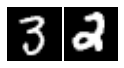

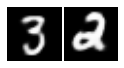

In [8]:
plt.close('all')
%matplotlib inline

num_checks = 2
x_gt, _ = mnist.train.next_batch(num_checks)
plot(x_gt)
plot(P(Q(x_gt)[0])[0].eval())
_ = 1 # prevent repeated plot in jupyter

In [9]:
def init_uninited_vars():
    unint_vars = []
    for var in tf.global_variables():
        if not tf.is_variable_initialized(var).eval():
            unint_vars.append(var)
    missingVarInit = tf.variables_initializer (unint_vars)
    sess.run(missingVarInit)

## HMC Inference

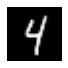

In [12]:
%matplotlib inline

inference_batch_size = 1
x_gt, _ = mnist.train.next_batch(inference_batch_size)
plot(x_gt)

T = 200000 # number of empirical samples in posterior
img_dim = 28
hmc_steps = T
leap_steps = 10
# print x_gt
# z = Normal(loc=tf.zeros([inference_batch_size, z_dim]), scale=tf.ones([inference_batch_size, z_dim])) # sample z
z = Normal(loc=Q(x_gt)[0], scale=tf.ones([inference_batch_size, z_dim])) # sample z

normalized_dec_x, dec_x_logits = P(z)
# print dec_x_logits.shape

X = Normal(loc=normalized_dec_x, scale=tf.ones([1, 28*28])/3.0)
  
# X = Normal(loc=dec_x, scale=tf.ones(img_dim)*sig) # likelihood distrib
qz = Empirical(params=tf.Variable(tf.zeros([T, inference_batch_size, z_dim])))

inference = ed.HMC({z: qz}, data={X: x_gt})

# inference.initialize(step_size=0.05, n_steps=leap_steps)
inference.initialize()
init_uninited_vars()

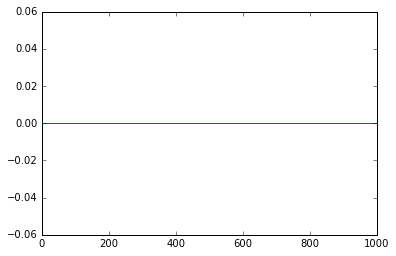

In [153]:
plt.plot(tf.squeeze(qz.params, 1).eval());

In [13]:
for i in range(hmc_steps):
    info_dict = inference.update()
    inference.print_progress(info_dict)

# inference.finalize()
# inference.run(variables=[], n_steps=hmc_steps)

200000/200000 [100%] ██████████████████████████████ Elapsed: 225s | Acceptance Rate: 0.200


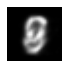

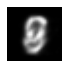

In [144]:
all_zeros = tf.Variable(tf.zeros([1, z_dim]))
sess.run(tf.variables_initializer([all_zeros]))
zeros_img, _ = P(all_zeros)
plot(zeros_img.eval())

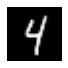

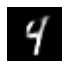

In [15]:
# inference.update()
keep_ratio = 0.2
to_keep_index = int((1-keep_ratio)*T)
qz_kept = Empirical(qz.params[to_keep_index:])

for element in range(inference_batch_size):
    z_test = qz_kept.sample(1)[:,element]
    img, _ = P(z_test)
    plot([x_gt[element]])
    plot(img.eval())

## Sample from Posterior and Reconstruct Image

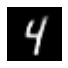

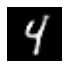

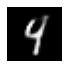

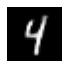

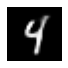

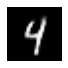

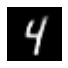

In [16]:
sample_to_vis = 5
qz_sample = qz_kept.sample(sample_to_vis)

for i in range(sample_to_vis):
    img, _ = P(qz_sample[i])
    plot(img.eval())
    
avg_img, _ = P(tf.reduce_mean(qz_sample, 0))
plot(avg_img.eval())

In [17]:
def l2_loss(x_gt,z_hmc):
    return tf.norm(x_gt-P(z_hmc)[0]).eval()

def recon_loss(x_gt,z_hmc): 
    return tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=P(z_hmc)[1], labels=x_gt), 1).eval()

In [18]:
num_to_best = 100

print recon_loss(x_gt,Q(x_gt)[0])
print l2_loss(x_gt,Q(x_gt)[0])
print "-----samples------"

samples_to_check = qz_kept.sample(num_to_best).eval()

best_sample = samples_to_check[0]

for sample in samples_to_check:
    
#     print recon_loss(x_gt,this_sample)
    if recon_loss(x_gt,sample)<recon_loss(x_gt,best_sample):
        best_sample = sample
        print 'yay'
    print recon_loss(x_gt,sample)
    print l2_loss(x_gt,sample)
    print "-------------"

[ 52.26885223]
2.32197
-----samples------
[ 48.14434052]
2.13651
-------------
yay
[ 46.65478516]
1.94468
-------------
[ 51.1394043]
2.37452
-------------
[ 47.9309845]
2.06424
-------------
yay
[ 45.65494537]
1.94129
-------------
[ 48.49896622]
2.17952
-------------
[ 51.32647705]
2.37309
-------------
[ 50.63134003]
2.20095
-------------
[ 46.28199768]
1.9905
-------------
[ 52.60238647]
2.45758
-------------
[ 48.34067535]
2.17812
-------------
[ 50.26340485]
2.22953
-------------
[ 47.69944763]
2.09656
-------------
[ 47.95613098]
2.1468
-------------
[ 47.55810928]
2.05888
-------------
[ 46.39728546]
2.01569
-------------
yay
[ 44.96559906]
1.87301
-------------
[ 49.12448502]
2.21418
-------------
[ 51.12766266]
2.3427
-------------
[ 53.61332321]
2.37049
-------------
[ 46.04524994]
1.86677
-------------
[ 49.82853699]
2.13201
-------------
[ 47.6476593]
2.0816
-------------
[ 49.57329178]
2.31466
-------------
[ 52.8939743]
2.39664
-------------
[ 49.69083405]
2.18388
------

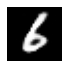

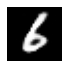

In [29]:
plot(P(best_sample)[0].eval())


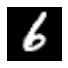

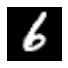

In [30]:
plot(x_gt)


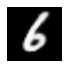

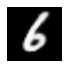

In [31]:

plot(P(Q(x_gt)[0])[0].eval())

In [203]:
best_sample.eval()

array([[-0.95212424, -0.06328762,  1.15245926, -1.89842546,  0.55811429,
         0.28280312,  1.36288333, -0.28184998,  0.9417032 ,  0.90358549,
         0.26905739,  0.08368081, -0.13203382, -0.92147446,  0.29938996,
         1.16178298, -0.01221067, -1.98057282,  0.38699692,  1.04599583,
         0.58394665, -0.99725592, -0.00950748, -0.27716935, -1.20402026,
         1.3431704 ,  1.10342491,  0.26597792,  0.59657621,  0.07928611,
         1.34685087, -0.62939471,  0.01714846,  1.36101007, -1.02673328,
        -0.79244512, -1.47798836, -0.52183121,  0.3043693 , -0.14730322,
         0.72478098, -0.76513886,  1.24852192, -0.74000216,  1.18806839,
         0.90432167,  1.0154866 , -1.30663764,  0.86737531,  0.79493713,
        -0.13313723, -0.70984679, -0.83949274,  0.4837237 ,  0.27060384,
         0.16487481, -1.33788598, -0.69531536,  0.00543284,  1.02623618,
        -1.54417562, -1.13814795,  1.41500294, -0.61554807,  0.60116261,
        -0.5156759 , -0.71881491,  1.18957877,  0.7

In [218]:
stored = qz_kept.sample(4)[:].eval()

In [57]:
qz_kept.prob(Q(x_gt)[0])

NotImplementedError: prob is not implemented

In [56]:
Q(x_gt)[0]

<tf.Tensor 'encoder_20/add_1:0' shape=(1, 100) dtype=float32>

# Visualizing Latent Stuff

In [143]:
dims = [0,1]

# hmc
num_samples = 500
hmc_samples = qz.sample(num_samples).eval()[:,:,dims]
hmc_samples = hmc_samples.reshape(num_samples,2)

# vae
z_mu, z_logvar = Q(x_gt)
z_mu, z_logvar = z_mu.eval()[:,dims], z_logvar.eval()[:,dims]
z_sig = np.sqrt(np.exp(z_logvar))


import matplotlib.mlab as mlab

def z_pdf(x):
    return mlab.normpdf(x, z_mu, z_sig)

z_pdf([0,0])


array([[ 0.39329466,  0.39197376]])

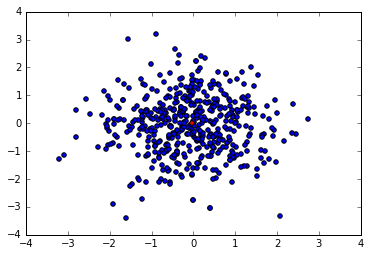

In [123]:
plt.scatter(hmc_samples[:,0],hmc_samples[:,1])

delta = 0.025
x = np.arange(-3.0, 3.0, delta)
y = np.arange(-2.0, 2.0, delta)
X, Y = np.meshgrid(x, y)
Z = 

plt.scatter(z_mu[:,0],z_mu[:,1],c='red')

In [116]:
print z_mu
print z

[[-0.03415328  0.01484325]]


In [73]:
example[:,:,dims]

array([[[ 1.09841859, -1.00078583]],

       [[ 0.36486715,  0.07354191]],

       [[ 0.33972636, -1.00488305]],

       [[-1.16158843, -0.40573901]],

       [[-0.77340281, -0.47521901]]], dtype=float32)

In [81]:
hmc_samples.reshape(100,2)

array([[-0.71766412,  0.55106211],
       [ 0.51440388,  0.83293486],
       [-1.69361949,  0.22254241],
       [ 1.09834707, -0.04426646],
       [ 0.08729209, -2.38114882],
       [ 0.93639302, -0.02984439],
       [ 1.03560019, -1.09900773],
       [ 1.9365437 ,  2.59694123],
       [-0.72813511,  1.38043725],
       [-0.22455654, -0.5990687 ],
       [ 1.13784456,  0.26290983],
       [ 0.02455321,  0.63259876],
       [-0.96345627, -0.7392078 ],
       [ 0.56158209, -0.40697479],
       [ 1.1787442 , -0.64984989],
       [ 0.12766266,  1.17939222],
       [ 1.36379325, -0.54766995],
       [-1.19331634,  0.36925721],
       [-1.2328949 ,  1.00660348],
       [ 1.01027083, -1.33736491],
       [ 1.15618086, -0.22541323],
       [-0.60926878, -0.88898516],
       [ 2.23491359, -0.16814062],
       [ 0.92787731,  0.00902253],
       [ 0.67106819, -1.57492197],
       [-0.50968361,  0.52206308],
       [ 0.33030197,  0.89059508],
       [ 1.53471553,  0.96007931],
       [-0.4101423 ,